In [1]:
import numpy as np
import scipy as sc
from matplotlib import pyplot as plt
import scipy.integrate as integrate
from astropy import units as u, constants as c

In [212]:
meff = 1

T = 0.2#*u.K
thickness = 0.00000005#m or 50 nm

#hbar=1.054572e-34#Js
#hbar=6.58212e-16#eVs
hbar = c.hbar.to(u.eV*u.s).value

#Kb = 1.380649e-23#J/K
#Kb = 8.61733e-5#eV/K
Kb = c.k_B.to(u.eV/u.K).value

mu = 0#(1*u.eV).value

J = u.J
si = 323e-4*u.Ohm*u.cm
si = si.to(u.Ohm*u.m)

Tc = 1.2#*u.K#K
N0 = 1.72e10#/u.J/u.um**3#m-3
TiN_resistivity = 800#Ohm*nm
Ti =TiN_resistivity/(thickness*u.m).to(u.nm).value
Sheet_impedance = 90e-8#si.value/thickness# 90 ohm/square

Delta = 1.76 * Kb *Tc
E=Kb*T
omega = 2*np.pi*np.logspace(6, 12, num=1000)#*u.rad/u.s
nqp = 2*N0*np.sqrt(2*np.pi*Kb*T*Delta)*np.e**(-Delta/(Kb*T))
Ti

16.000000000000004

In [213]:
#plt.plot(hbar*omega*u.eV,np.exp(-hbar*omega/Kb/T))
#plt.yscale('log')
#plt.xscale('log')
#plt.axvline(x = Delta, ymin = 0.1, ymax = 0.975, color = 'r')
#plt.show()

In [214]:
X = (hbar*omega)/(2*Kb*T)
sig1= ((2*Delta)/(hbar*omega))*(nqp/N0)*(1/np.sqrt(2*np.pi*Kb*T*Delta))*np.sinh(X)*sc.special.kn(0,X)/Sheet_impedance
sig2= ((np.pi*Delta)/(hbar*omega))*(1-(nqp/(2*N0*Delta))*(1+np.sqrt(2*Delta/(np.pi*Kb*T))*(np.e**-X)*sc.special.jv(0,X)))/Sheet_impedance

In [215]:
Rs = sig1/((sig1**2 + sig2**2)*thickness)*u.Ohm
Xs = sig2/((sig1**2 + sig2**2)*thickness)*u.Ohm

In [216]:

#plt.scatter(omega/(2*np.pi),Rs,s=.1,c='g')
#plt.scatter(omega/(2*np.pi),Xs,s=.1,c='b')
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

In [217]:
#plt.scatter(omega/(2*np.pi),X,s=.1,c='g')
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

In [218]:
def Fermi(E,T,Kb,mu):
    A = (E-mu)/Kb/T
    B = np.exp(A)
    #print(f"E={E}, E/Kb/T={A}, np.exp(E/Kb/T)={B}, R={1/(1+B)}")
    #print(f"E/KbT={A}")
    return (1/(1 + B))
    #return (1/(1 + B))
    #return np.exp(-A) #Boltzmann Approximation

In [219]:
def S1Fermi(E,T,Kb,mu,hbar,w):
    A = (E-mu)/Kb/T
    #print(f"E={E}, E/Kb/T={A}, np.exp(E/Kb/T)={B}, R={1/(1+B)}")
    #print(f"R={1/A}")
    phi = hbar*w/Kb/T
    return(1/(1+np.exp(A))) - (1/(1+np.exp(A+phi)))
    #return (1/(1/A +np.exp(phi)))
    if phi > 2e2:
        if A > 2e2:
            return 1/A
        else:
            return np.exp(A)/(1 + np.exp(A))
    elif A > 2e2:
        return 1/A
    elif A < -2e2:
        return np.exp(A+phi)
    else:
        return (1/(1+np.exp(A))) - (1/(1+np.exp(A+phi)))

In [220]:
def S1Integrand(E,w,T,hbar,Delta,Kb,mu):
    #A = (1 - np.exp(hbar*w))*np.exp(E)
    if np.abs((E-mu)/Kb/T) > 1e1:
        A = S1Fermi(E,T,Kb,mu,hbar,w)
        #print(f"A={A}")
    else:
        A = (Fermi(E,T,Kb,mu)-Fermi((E+(hbar*w)),T,Kb,mu))
    
    B = (E**2 + Delta**2 + (hbar*w*E))
    C = np.sqrt(np.abs(E**2 - Delta**2))
    D = np.sqrt(np.abs((E+(hbar*w))**2 -Delta**2))
    #print(f"R={A*B/C/D}")
    #print(f"A={A}, B={B}, C={C}, D={D}, R={(A*B)/(C*D)}")
    return (A*B)/(C*D)

In [221]:
def S2Integrand(E,w,T,hbar,Delta,Kb,mu):
    A = (1-2*Fermi(E+(hbar*w),T,Kb,mu))
    B = E**2 +Delta**2 + (hbar*w*E)
    C = np.sqrt(np.abs(E**2 - Delta**2))
    D = np.sqrt(np.abs((E+(hbar*w))**2 -Delta**2))
    return (A*B)/(C*D)

In [222]:
def S3Integrand(E,w,T,hbar,Delta,Kb,mu):
    A = (1-2*Fermi(E+(hbar*w),T,Kb,mu))
    B = E**2 +Delta**2 + hbar*w*E
    C = np.sqrt(np.abs(Delta**2 - E**2))
    D = np.sqrt(np.abs((E+(hbar*w))**2 -Delta**2))
    return (A*B)/(C*D)

In [223]:
S1 = []
S2 = []
for w in omega:
    if ((hbar*w) < (2*Delta)):
        S1A = (2/(hbar*w))*integrate.quad(S1Integrand,Delta,np.inf,args=(w,T,hbar,Delta,Kb,mu),limit=100)[0]#Delta,10
        S1 = np.append(S1,S1A)
    else:
        S1A = (2/(hbar*w))*integrate.quad(S1Integrand,Delta,np.inf,args=(w,T,hbar,Delta,Kb,mu),limit=100)[0]#Delta,10
        S1B = (1/(hbar*w))*integrate.quad(S2Integrand,Delta-(hbar*w),-Delta,args=(w,T,hbar,Delta,Kb,mu),limit=100)[0]
        S1 = np.append(S1,(S1A+S1B))
    S2 = np.append(S2,((1/(hbar*w))*integrate.quad(S3Integrand,max(Delta-(hbar*w),-Delta),Delta,args=(w,T,hbar,Delta,Kb,mu),limit=100)[0]))
    #print(f"S1A={S1A}")
    if ((len(S1) % 100) == 0):
        print(len(S1))
S1 = S1/Sheet_impedance
S2 = S2/Sheet_impedance

/tmp/ipykernel_2215/2555799553.py:6: RuntimeWarning: overflow encountered in exp
  return(1/(1+np.exp(A))) - (1/(1+np.exp(A+phi)))


100
200
300
400
500
600
700
800
900


/tmp/ipykernel_2215/4214656209.py:11: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  S2 = np.append(S2,((1/(hbar*w))*integrate.quad(S3Integrand,max(Delta-(hbar*w),-Delta),Delta,args=(w,T,hbar,Delta,Kb,mu),limit=100)[0]))


1000


In [224]:
#plt.scatter(omega/(2*np.pi),S1,s=.1,c='g')
#plt.scatter(omega/(2*np.pi),S2,s=.1,c='b')
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

In [225]:
Rs2 = (1/thickness)*(np.abs(S1)/(S1**2 + S2**2))*u.Ohm
Xs2 = (1/thickness)*(np.abs(S2)/(S1**2 + S2**2))*u.Ohm

In [226]:
#plt.scatter(omega/(2*np.pi),Rs2,s=.1,c='g')
#plt.scatter(omega/(2*np.pi),Xs2,s=.1,c='b')
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

In [227]:
Rs2

<Quantity [1.87936062e-65, 1.93206352e-65, 1.98624467e-65, 2.04194441e-65,
           2.09920654e-65, 2.15807465e-65, 2.21859329e-65, 2.28080889e-65,
           2.34476918e-65, 2.41052315e-65, 2.47812098e-65, 2.54761441e-65,
           2.61905645e-65, 2.69250187e-65, 2.76800686e-65, 2.84562904e-65,
           2.92542792e-65, 3.00746480e-65, 3.09180152e-65, 3.17850353e-65,
           3.26763659e-65, 3.35926925e-65, 3.45347127e-65, 3.55031519e-65,
           3.64987431e-65, 3.75222544e-65, 3.85744610e-65, 3.96561808e-65,
           4.07682265e-65, 4.19114572e-65, 4.30867443e-65, 4.42949892e-65,
           4.55371125e-65, 4.68140689e-65, 4.81268279e-65, 4.94764018e-65,
           5.08638165e-65, 5.22901330e-65, 5.37564471e-65, 5.52638759e-65,
           5.68135738e-65, 5.84067248e-65, 6.00445490e-65, 6.17283015e-65,
           6.34592598e-65, 6.52387577e-65, 6.70681489e-65, 6.89488442e-65,
           7.08822704e-65, 7.28699040e-65, 7.49132757e-65, 7.70139432e-65,
           7.91735073e-65

In [228]:
#plt.scatter(omega/(2*np.pi),Rs,s=.1,c='g')
#plt.scatter(omega/(2*np.pi),Xs,s=.1,c='b')
#plt.scatter(omega/(2*np.pi),Rs2,s=.1,c='g')
#plt.scatter(omega/(2*np.pi),Xs2,s=.1,c='b')
#plt.yscale('log')
#plt.xscale('log')
#plt.show()

<IPython.core.display.Javascript object>


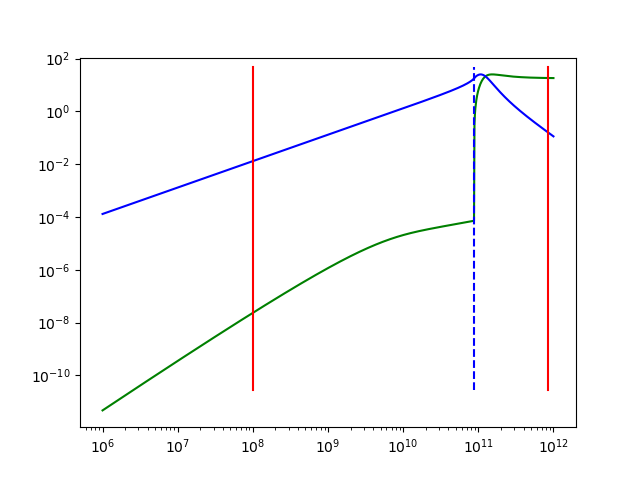

In [233]:
%matplotlib notebook
#diff = Xs2[np.min(np.where(omega/2/np.pi >= 5e10))]-Xs[np.max(np.where(omega/2/np.pi < 5e10))]
R = np.concatenate((Rs[np.where(Rs > Rs2)], Rs2[np.where(Rs2 > Rs)]))
#plt.plot(omega[np.where(Rs > Rs2)]/(2*np.pi),Rs[np.where(Rs > Rs2)]/Sheet_impedance,c='g')
#plt.scatter(omega[np.where(omega/2/np.pi < 8e10)]/(2*np.pi),Xs[np.where(omega/2/np.pi < 8e10)],s=.1,c='b')
#plt.plot(omega[np.where(Rs2 > Rs)]/(2*np.pi),Rs2[np.where(Rs2 > Rs)]/Sheet_impedance,c='g')
#plt.scatter(omega[np.where(omega/2/np.pi >= 8e10)]/(2*np.pi),Xs2[np.where(omega/2/np.pi >= 8e10)],s=.1,c='b')
plt.plot(omega/(2*np.pi)*u.Hz,R,c='g')
plt.plot(omega/(2*np.pi)*u.Hz,Xs2,c='b')
plt.yscale('log')
plt.xscale('log')
plt.axvline(x = 100e6, ymin = 0.1, ymax = 0.975, color = 'r')
plt.axvline(x = 850e9, ymin = 0.1, ymax = 0.975, color = 'r')
plt.axvline(x = 2*Delta*241799050402293, ymin = 0.1, ymax = 0.975, color = 'b',linestyle='--')
plt.show()

<IPython.core.display.Javascript object>


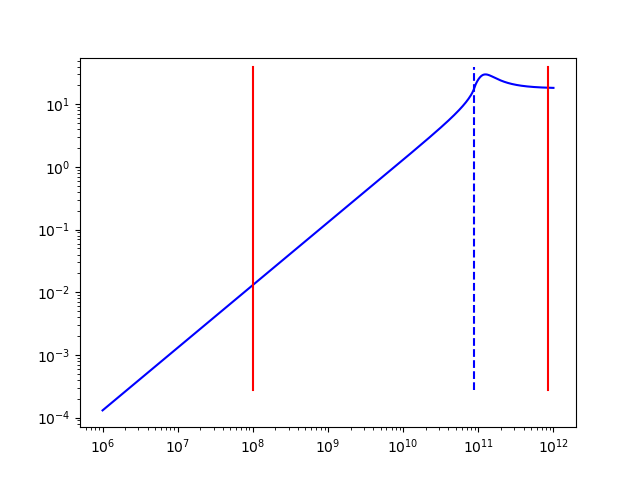

In [232]:
imp = R + 1j*Xs2
mag = np.sqrt(R**2 + Xs2**2)
plt.plot(omega/(2*np.pi)*u.Hz,mag,c='b')
plt.yscale('log')
plt.xscale('log')
plt.axvline(x = 100e6, ymin = 0.1, ymax = 0.975, color = 'r')
plt.axvline(x = 850e9, ymin = 0.1, ymax = 0.975, color = 'r')
plt.axvline(x = 2*Delta*241799050402293, ymin = 0.1, ymax = 0.975, color = 'b',linestyle='--')
plt.show()

In [127]:
hbar*omega/Kb/T

array([2.39962154e-04, 2.43303724e-04, 2.46691828e-04, 2.50127112e-04,
       2.53610234e-04, 2.57141860e-04, 2.60722665e-04, 2.64353335e-04,
       2.68034563e-04, 2.71767053e-04, 2.75551520e-04, 2.79388687e-04,
       2.83279289e-04, 2.87224068e-04, 2.91223780e-04, 2.95279190e-04,
       2.99391073e-04, 3.03560216e-04, 3.07787416e-04, 3.12073481e-04,
       3.16419231e-04, 3.20825498e-04, 3.25293124e-04, 3.29822963e-04,
       3.34415882e-04, 3.39072760e-04, 3.43794486e-04, 3.48581965e-04,
       3.53436111e-04, 3.58357852e-04, 3.63348132e-04, 3.68407902e-04,
       3.73538133e-04, 3.78739803e-04, 3.84013909e-04, 3.89361460e-04,
       3.94783477e-04, 4.00280997e-04, 4.05855073e-04, 4.11506771e-04,
       4.17237170e-04, 4.23047368e-04, 4.28938475e-04, 4.34911618e-04,
       4.40967940e-04, 4.47108598e-04, 4.53334767e-04, 4.59647639e-04,
       4.66048419e-04, 4.72538334e-04, 4.79118622e-04, 4.85790545e-04,
       4.92555376e-04, 4.99414410e-04, 5.06368959e-04, 5.13420354e-04,
      